<a href="https://colab.research.google.com/github/freejae98/freejae98.github.io/blob/master/2022_03_29_Steel_REG_ML_4_2%EB%8B%A8%EA%B3%84(N_F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [3]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)

### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

### scaling of X_train and X_test by X_train_scaler
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
# X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)

### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif

In [4]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [6]:
#################################################################################
#
# ----- Feature N, MLP 버전 -------
#
#################################################################################


# Data Loading - 상해선물 4개월물
df = pd.read_excel('/content/Rev_dataset.xlsx')
df.set_index('Date', inplace=True)


# Feature Engineering
# raw_feR = feature_engineering(raw_all)
### Reality ###
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

print(df.columns)

Index(['index', 'Target', 'shift_down', 'week', 'MA5', 'MA5_f', 'w_inc',
       'w_inc_UD', 'w_inc_CT', '1)환율-RMB', '1)철광석-중국', '1)원료탄', '1)철스크랩',
       '1)열연-미국', '1)열연-뭄바이', '1)열연-천진', '1)열연-상해', '1)열연-중국수출', '1)열연-북유럽',
       '1)열연-남유럽', '1)열연-한국', '1)GI-상해', '1)GI-중국수출', '1)GI-북유럽', '1)GI-남유럽',
       '1)GI-미국', '1)GI-미중서', '1)GI-한국', '2)열연-중국천진', '2)열연-중국상해',
       '2)중국-Plate상해', '2)중국-Flat재고', '3)Rebar-중국', '3)W/Rod-상해',
       '3)Billet-중국내수', '3)중국-Long재고', '3)중국-판재+롱재고', '4)철광석', '4)호주-석탄',
       '4)중국-석탄내수', '4)철스크랩-터키수입가', '5)두바이', '5)WTI', '5)BDI', '5)BSI-해운지수',
       'Year', 'Quater', 'Quater_ver2', 'Month', 'Day', '6)pre close',
       '6)Pre settle', '6)Open', '6)High', '6)Low', '6)Close', '6)Settle',
       '6)ch1', '6)ch2', '6)Volume', '6)Amount', '6)OI', '7)Corvid_순증_한국',
       '7)Corvid_순증_중국', '7)Corvid_순증_인도', '7)Corvid_순증_일본', '7)Corvid_순증_대만',
       '7)Corvid_순증_태국', '7)Corvid_순증_캐나다', '7)Corvid_순증_멕시코',
       '7)Corvid_순증_미국', '7)Corvid_순증_브라질', '7)Corv

In [22]:
Y_colname = ['MA5_f']
# X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
# X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_colname = ['MA5', '6)Close', '2)중국-Flat재고', '3)Rebar-중국', '3)W/Rod-상해', '5)WTI', '1)GI-미국', '1)GI-미중서', '1)GI-한국',
       '6)Volume', '1)철광석-중국', '1)원료탄', '3)중국-판재+롱재고', '5)BSI-해운지수', '7)Corvid_순증_중국', 'is_holiday']


raw_all = df.loc[df.index >= '2019-12-30', :]


# Parameters
criteria = '2021-09-01'

X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_all, Y_colname, X_colname, criteria)


Train_size: (437, 79) Test_size: (110, 79)
X_train: (437, 16) Y_train: (437, 1)
X_test: (110, 16) Y_test: (110, 1)


In [23]:

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
# sequence = 60
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train = scaler_X_tr.fit_transform(X_train_feR)
Y_train = scaler_Y_tr.fit_transform(Y_train_feR)
X_test = scaler_X_tr.transform(X_test_feR)
Y_test = scaler_Y_tr.transform(Y_test_feR)

## Retype and Reshape
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (437, 16) Y_train: (437, 1)
X_test: (110, 16) Y_test: (110, 1)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               2176      
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
14/14 [==============================]

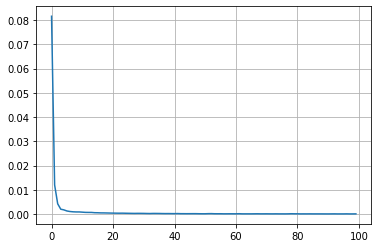

4/4 [==============================] - 0s 2ms/step - loss: 1.2919e-15


,MAE,MSE,MAPE
Train,6.61,70.93,1.03
Test,22.89,708.11,2.89


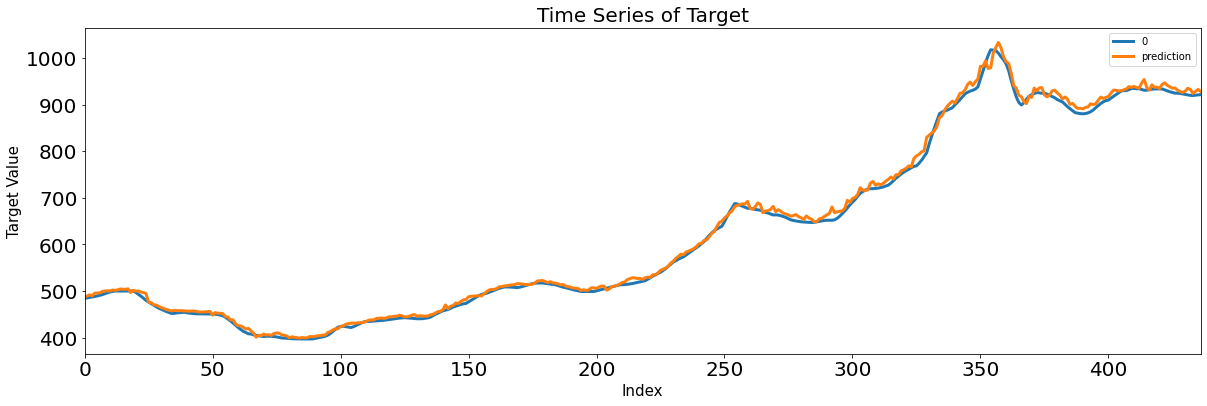

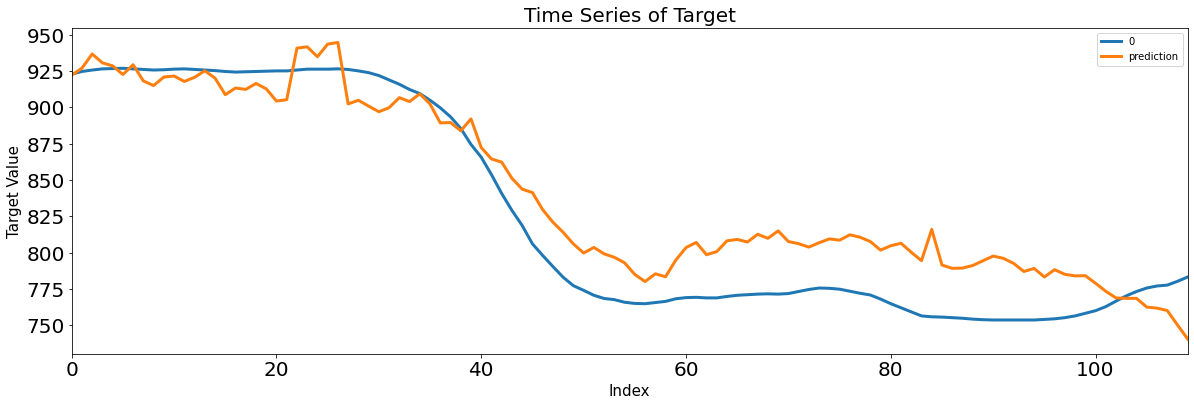

In [24]:
#################################################################################
#
# ----- Feature N, MLP 버전 -------
#
#################################################################################

# MLP
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(dropout_ratio)) 
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)


X_train: (421, 16, 16) Y_train: (421, 1)
X_test: (94, 16, 16) Y_test: (94, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 16, 128)           18560     
                                                                 
 dropout_22 (Dropout)        (None, 16, 128)           0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 16, 64)            12352     
                                                                 
 dropout_23 (Dropout)        (None, 16, 64)            0         
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 1)                 1025      
                                         

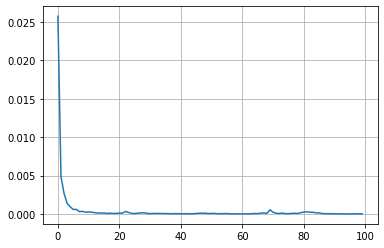

3/3 [==============================] - 0s 5ms/step - loss: 4.6677e-15


,MAE,MSE,MAPE
Train,1.62,4.80,0.25
Test,51.50,"3,852.20",6.19


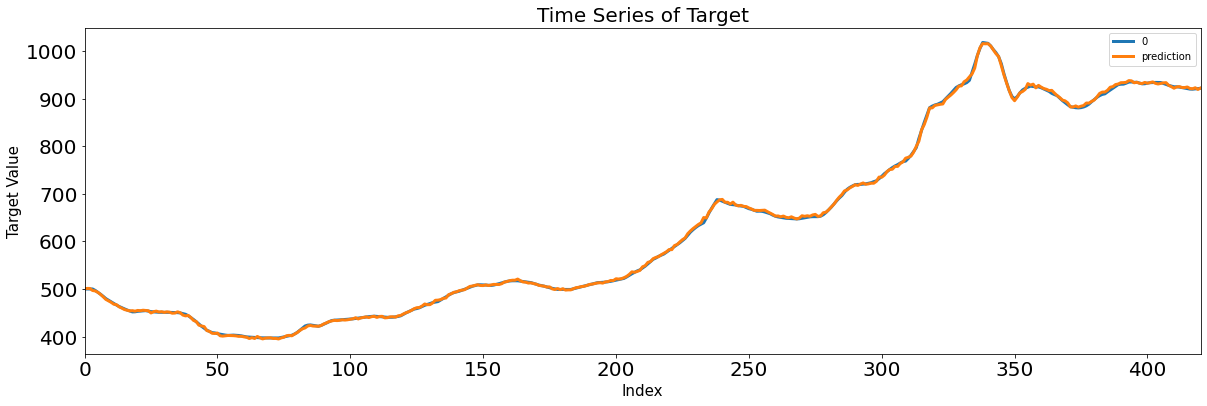

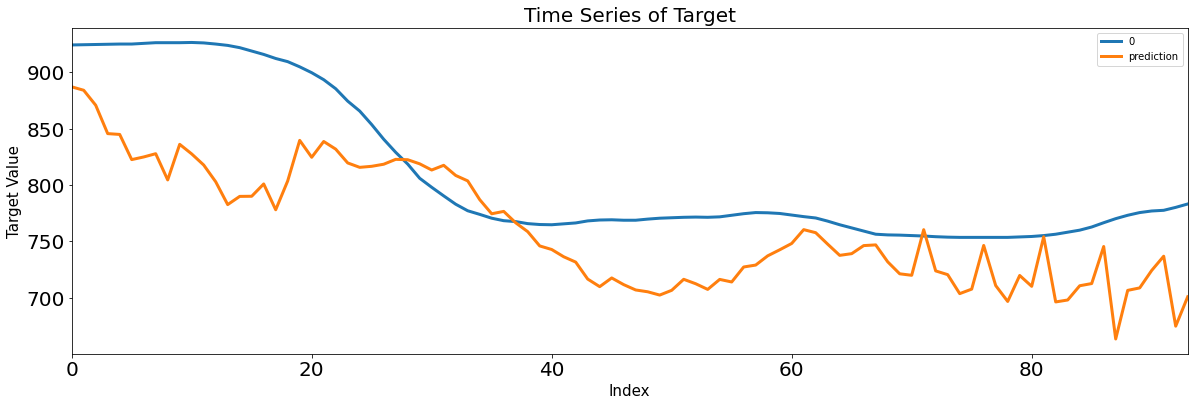

In [25]:
#################################################################################
#
# ----- Feature N, RNN 버전 -------  sequence = 16
#
#################################################################################

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 16
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0


# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train_feR)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train_feR)
X_test_scaled = scaler_X_tr.transform(X_test_feR)
Y_test_scaled = scaler_Y_tr.transform(Y_test_feR)



## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)

In [26]:
#################################################################################
#
# ----- Feature N, LSTM 버전 -------  sequence = 24
#
#################################################################################

X_train: (421, 16, 16) Y_train: (421, 1)
X_test: (94, 16, 16) Y_test: (94, 1)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 16, 128)           74240     
                                                                 
 dropout_24 (Dropout)        (None, 16, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 123,713
Trainable params: 123,713
Non-trainable params: 0
___________________________________

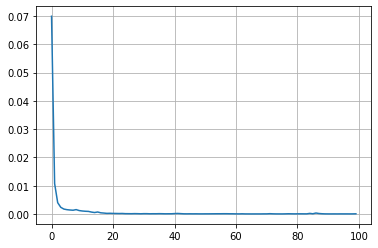

3/3 [==============================] - 0s 7ms/step - loss: 1.2850e-15


,MAE,MSE,MAPE
Train,3.11,20.21,0.49
Test,31.14,"1,984.39",3.59


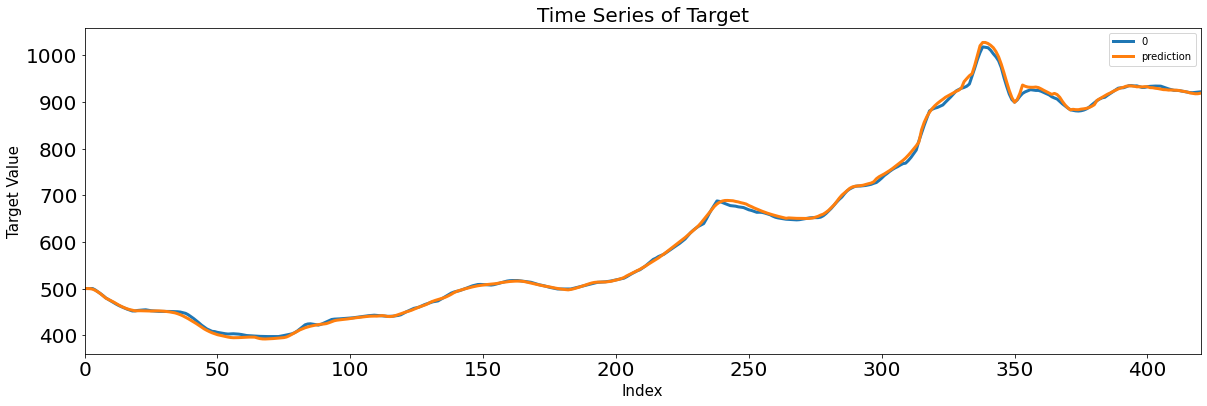

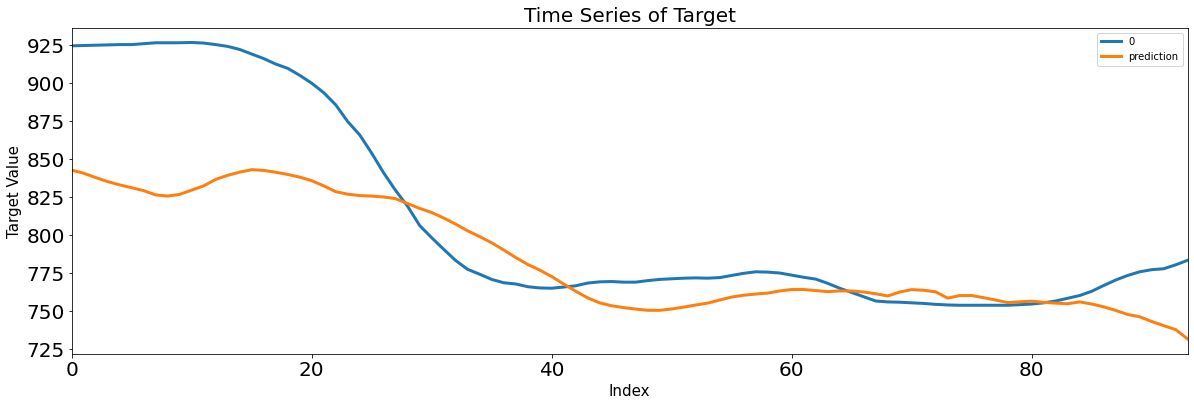

In [27]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 16
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0


# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train_feR)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train_feR)
X_test_scaled = scaler_X_tr.transform(X_test_feR)
Y_test_scaled = scaler_Y_tr.transform(Y_test_feR)



## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(LSTM(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(LSTM(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

In [28]:
#################################################################################
#
# ----- Feature N, GRU 버전 -------  sequence = 24
#
#################################################################################

X_train: (403, 34, 16) Y_train: (403, 1)
X_test: (76, 34, 16) Y_test: (76, 1)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 34, 128)           56064     
                                                                 
 dropout_26 (Dropout)        (None, 34, 128)           0         
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 93,377
Trainable params: 93,377
Non-trainable params: 0
_____________________________________

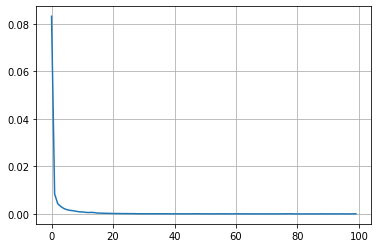

3/3 [==============================] - 0s 9ms/step - loss: 8.6481e-16


,MAE,MSE,MAPE
Train,2.78,16.42,0.41
Test,30.07,"1,209.77",3.83


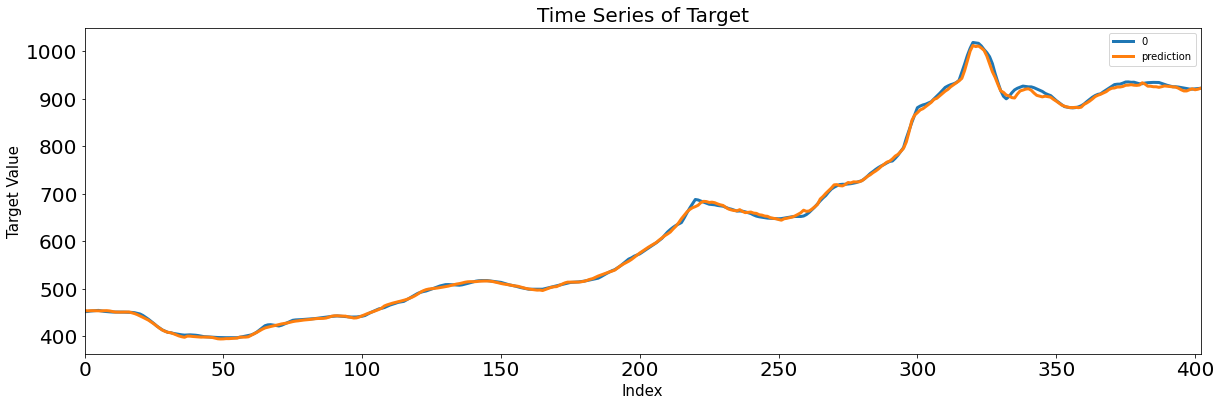

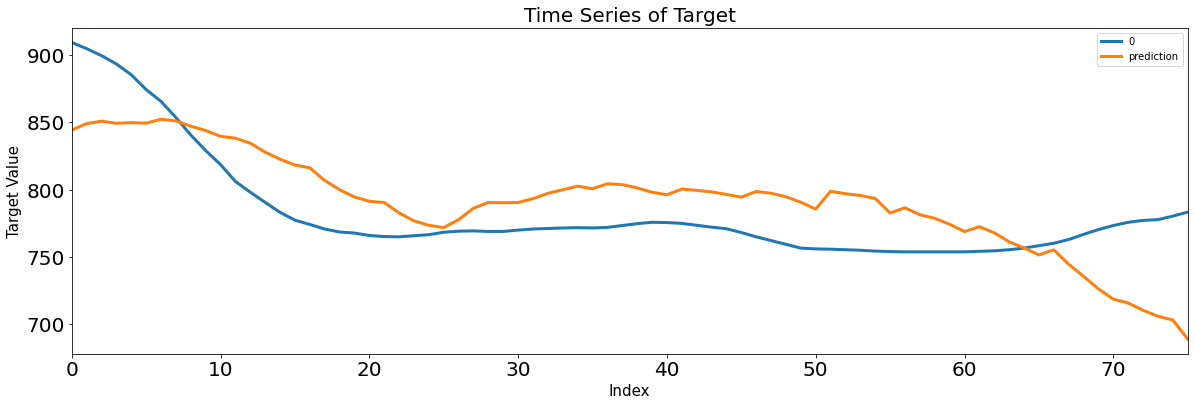

In [29]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 34
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train_feR)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train_feR)
X_test_scaled = scaler_X_tr.transform(X_test_feR)
Y_test_scaled = scaler_Y_tr.transform(Y_test_feR)


## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(GRU(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(GRU(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)
